### Systematic study

In [2]:
# AutoML
import sys
main_path = '../'
sys.path.append(main_path + 'code/auto_ml')
sys.path.append(main_path + 'code/processing')
sys.path.append(main_path + 'code/functions')
sys.path.append(main_path + 'code/models')
sys.path.append(main_path + 'data')

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from auto_ml import AutoML
from comparator import Comparator

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_path = '../data/systematic_study_data/'

# To run all the study
#datasets = ['iris', 'mushrooms', 'boston', 'adult', 'mimic']
#labels = ['species', 'class', 'medv', 'income', 'DIED']
#generators = ['mg', 'kd', 'rf', 'wgan']
#scorings = ['acc', 'acc', 'r2', 'acc', 'acc']

# To run a given configuration
datasets = ['iris']
labels = ['species']
generators = ['rf']
scorings = ['acc']

# !!! WGAN: ONLY 5 FEATURES

In [4]:
def label_encode(y, dropna=False):
    
    le = LabelEncoder()
    if dropna:
        y = y.dropna()
        
    return le.fit_transform(y)


def task_score(X_train, y_train, X_test, y_test, scoring='mse'):
        
    if scoring == 'mse':
        model = RandomForestRegressor(n_estimators=50)
        model.fit(X_train, y_train)
        return mean_squared_error(y_test, model.predict(X_test)) # MSE
    
    elif scoring == 'r2':
        model = RandomForestRegressor(n_estimators=50)
        model.fit(X_train, y_train)
        return model.score(X_test, y_test) # r2
    
    elif scoring == 'acc':
        model = RandomForestClassifier(n_estimators=50)
        model.fit(X_train, y_train)
        return accuracy_score(y_test, model.predict(X_test))
    
    else:
        raise OSError('{} scoring is not taken in charge'.format(scoring))
        

def show_task_score(train_X, train_y, test_X, test_y, gen_X, gen_y, scoring):
    
    scores = []

    # train / test
    scores.append(task_score(train_X, train_y, test_X, test_y, scoring=scoring))

    # train / gen
    scores.append(task_score(train_X, train_y, gen_X, gen_y, scoring=scoring))

    # gen / gen
    gen_X_train, gen_X_test, gen_y_train, gen_y_test = train_test_split(gen_X, gen_y, test_size=0.3)
    scores.append(task_score(gen_X_train, gen_y_train, gen_X_test, gen_y_test, scoring=scoring))

    x = [1, 2, 3]

    legends = {1:('Trained on train set / Tested on test set','b'), 
          2:('Trained on train set / Tested on generated dataset','g'), 
          3:('Trained and tested on generated dataset (with a split)','orange')}

    ax1 = plt.subplot(111)

    for j in range(len(x)):
        ax1.bar(x[j], scores[j], width=0.8, bottom=0.0, align='center', color=legends[x[j]][1], alpha=0.6, label=legends[x[j]][0])

    ax1.set_xticks(x)
    ax1.set_xticklabels([i for i in x])

    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
              ncol=1, fancybox=True, shadow=True)

    plt.xlabel('Training and test set')
    plt.ylabel(scoring + 'score')
    if scoring == 'acc':
        plt.ylim(0, 1) # same scale for every plots

    #plt.savefig(fig_path+dataset+'_'+generator+'_score.png') # out of figure bounds
    plt.show()

In [5]:
# Convert to AutoML format if necessary

#versions = generators
#versions = ['train_sdv', 'test_sdv']
#for v in versions:
#    for d in datasets:
#        name = d + '_' + v
#        input_dir, basename = data_path + d, name # TMP
#        D = AutoML.from_csv(input_dir, basename, name+'.csv')

### Run the experiment

iris
rf

2 datasets detected: ready for comparison.
Explained variance ratio of the 5 components: 
 [0.75364005 0.15943482 0.06329037 0.01889279 0.00474198]
Explained variance ratio of the 5 components: 
 [7.98235335e-01 1.46573707e-01 3.99628296e-02 1.44415188e-02
 7.86609908e-04]


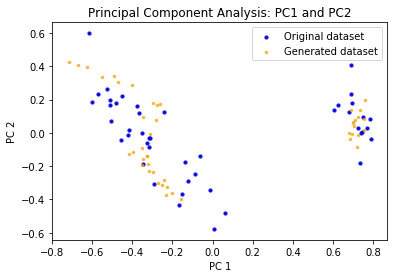

Nearest neighbors metric


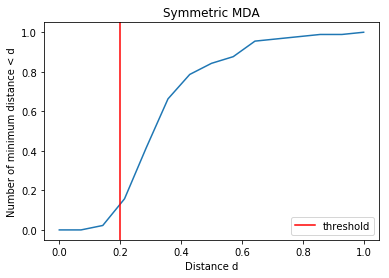

** Privacy: **0.9973247726056714

** Resemblance: **0.8089218833600855

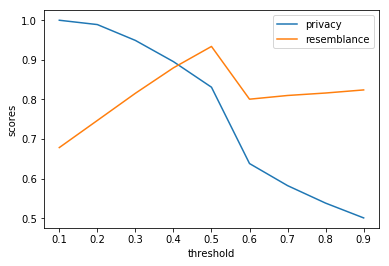

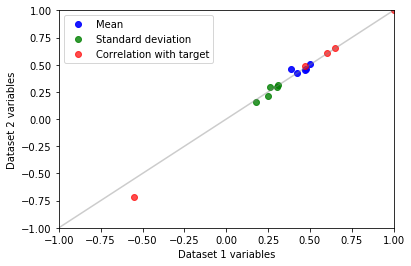

/usr/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


                   precision    recall  f1-score   support

 Original dataset       0.67      0.67      0.67         9
Generated dataset       0.86      0.86      0.86        21

      avg / total       0.80      0.80      0.80        30





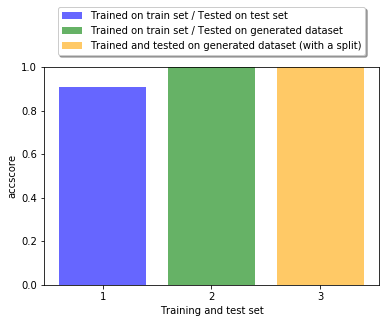

In [6]:
fig_path = '/home/adrien/Images/systematic_study/'

# Loop on datasets
for i, dataset in enumerate(datasets):
    
    # Loop on generative models
    for generator in generators:

        # Intro
        print(dataset)
        print(generator)
        print()
        
        label = labels[i]
        scoring = scorings[i]

        # A) Datasets
        # 1) Train original dataset
        train = AutoML(data_path + dataset, dataset + '_train_sdv')
        train_data = train.get_data()
        #train_y = train_data[label]
        # class, need decoded dataset
        train_cl = pd.read_csv(data_path + dataset + '/' + dataset +'_train_sdv_normal.csv')
        train_y = label_encode(train_cl[label])
        
        # 2) Test original dataset
        test = AutoML(data_path + dataset, dataset + '_test_sdv')
        test_data = test.get_data()
        #test_y = test_data[label]
        # class, need decoded dataset
        test_cl = pd.read_csv(data_path + dataset + '/' + dataset +'_test_sdv_normal.csv')
        test_y = label_encode(test_cl[label])
        
        # 3) Generated dataset
        gen = AutoML(data_path + dataset, dataset +'_'+ generator)
        gen_data = gen.get_data()
        #gen_y = gen_data[label] # should not be needed
        # class, need decoded dataset
        gen_cl = pd.read_csv(data_path + dataset + '/' + dataset +'_'+ generator + '_normal.csv')
        
        # NaN values appeared during decoding 
        # We want to drop NaN in the decoded y and then report the new index to gen_X
        # To be able to train and test a classifier on the generated data
        y = gen_cl[label].dropna()
        idx = y.index
        gen_y = label_encode(y)
        
        # Drop label
        train_X = train_data.drop([label], axis=1)
        test_X = test_data.drop([label], axis=1)
        gen_X = gen_data.drop([label], axis=1).loc[idx]
        ##############################

        # B) Metrics
        # 1) Plots
        comparator = Comparator(test, gen)
        
        size = 1 # PCA plot points size
        if dataset in ['iris', 'boston']: # For small datasets ~ train_X.shape[0] < 1000
            size = 5
            
        alpha2 = .8 # PCA plot orange points opacity
        if dataset in ['adult', 'mimic']: # For big datasets  ~ train_X.shape[0] > 10000
            alpha2 = 0.3
        
        comparator.show_pca(save=fig_path+dataset+'_'+generator+'_pca.png', label1='Original dataset', label2='Generated dataset', size=size, alpha2=alpha2)
        ##comparator.show_lda(label)
        comparator.show_mda(save=fig_path+dataset+'_'+generator+'_mda.png', same_size=True)
        comparator.show_mda_threshold(save=fig_path+dataset+'_'+generator+'_threshold.png', same_size=True)
        comparator.compare_marginals(metric='all', target=label, save=fig_path+dataset+'_'+generator+'_marginals.png')
        
        # 2) Discriminant score
        clf = MLPClassifier(hidden_layer_sizes=(100, 200))
        comparator.show_classifier_score(clf=clf, processed=False, same_size=True, label1='Original dataset', label2='Generated dataset')
        
        # 3) Tasks scores
        
        show_task_score(train_X, train_y, test_X, test_y, gen_X, gen_y, scoring)